In [ ]:
import os
import zipfile
import random
import shutil
import numpy as np
from shutil import copyfile
import matplotlib.pylab as plt

import tensorflow as tf
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import optimizers
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.5.0
• Using TensorFlow Hub Version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Found.


In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [ ]:
os.environ['KAGGLE_USERNAME'] = "bayuadityatriwibowo" # username from the json file
os.environ['KAGGLE_KEY'] = "2afe27d8d4c9644debf51b8e88ad9dbb" # key from the json file
!kaggle datasets download -d bayuadityatriwibowo/bangkits-peasent-dataset --path '/tmp/'

 99% 612M/621M [00:07<00:00, 70.6MB/s]
100% 621M/621M [00:07<00:00, 83.8MB/s]


In [ ]:
local_zip = '/tmp/bangkits-peasent-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
TRAINING_DIR = "/tmp/Bangkit's Peasant Dataset/train/"

Corn_healthy = os.path.join("/tmp/Bangkit's Peasant Dataset/train/Corn_(maize)___healthy")
Potato_healthy = os.path.join("/tmp/Bangkit's Peasant Dataset/train/Potato___healthy")
Tomato_healthy = os.path.join("/tmp/Bangkit's Peasant Dataset/train/Tomato___healthy")

print('total training Healthy Corn images:', len(os.listdir(Corn_healthy)))
print('total training Healthy Potato images:', len(os.listdir(Potato_healthy)))
print('total training Healthy Tomato images:', len(os.listdir(Tomato_healthy)))

Corn_files = os.listdir(Corn_healthy)
print(Corn_files[:10])
Potato_files = os.listdir(Potato_healthy)
print(Potato_files[:10])
Tomato_files = os.listdir(Tomato_healthy)
print(Tomato_files[:10])

total training Healthy Corn images: 1859
total training Healthy Potato images: 1824
total training Healthy Tomato images: 1926
['500c13c7-2b8e-43ea-b842-154de7cf7f50___R.S_HL 8003 copy 2_flipLR.jpg', '07317e94-df27-4c29-bd69-6c5e54a0457d___R.S_HL 7998 copy_flipLR.jpg', '4bffb932-0f73-4ea5-b1b3-ffbef8c5f07d___R.S_HL 7895 copy.jpg', 'aad5f376-fca2-4eed-8174-b9bc86654441___R.S_HL 0629 copy 2.jpg', '526e6386-1a1f-4ac3-a49b-770d588faf4f___R.S_HL 7961 copy 2.jpg', 'cf13f3b8-d610-4b17-ace1-07a382cb620b___R.S_HL 8318 copy 3.jpg', 'dea7aabe-2263-41ea-8c14-4edb19ada67e___R.S_HL 5516 copy_flipLR.jpg', '4a771d9d-4dc5-48dd-9b05-239246a8dc66___R.S_HL 5494 copy 2_flipLR.jpg', '026bd735-b9f4-4eab-86f3-23df15dbec95___R.S_HL 7938 copy.jpg', '2a46f1cb-9c54-481c-a61f-d3729d5cfc3e___R.S_HL 8315 copy_flipLR.jpg']
['369479a9-3c28-4d77-8731-9ae54e719af3___RS_HL 1785_flipTB.JPG', 'f0036dfd-9f46-4f2f-9001-5973495f2171___RS_HL 1849_new200degFlipLR.JPG', '413bc2e9-eb2a-48fd-ba65-48b5121fd85c___RS_HL 4200_newGRR.J

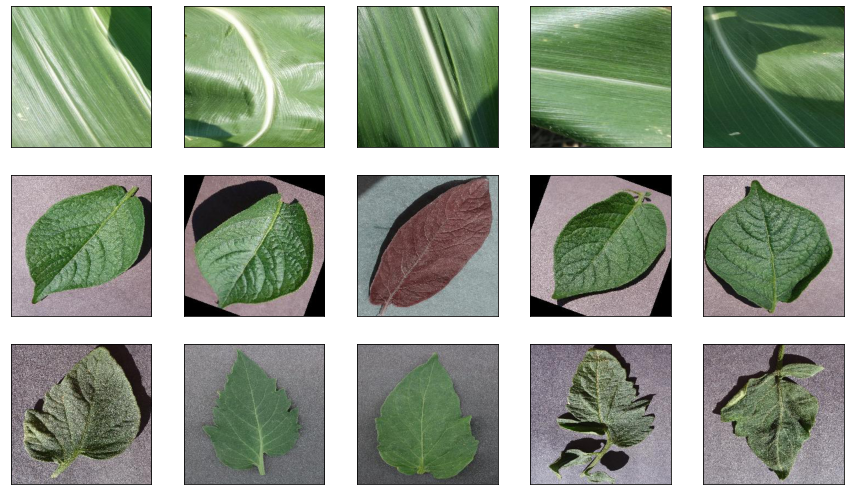

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 5

Corn_img = [os.path.join(Corn_healthy, fname) 
                for fname in Corn_files[pic_index-5:pic_index]]
Potato_img = [os.path.join(Potato_healthy, fname) 
                for fname in Potato_files[pic_index-5:pic_index]]
Tomato_img = [os.path.join(Tomato_healthy, fname) 
                for fname in Tomato_files[pic_index-5:pic_index]]

plt.figure(figsize=(15,15))
for i, img_path in enumerate(Corn_img+Potato_img+Tomato_img):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img)
plt.show()

In [ ]:
TRAINING_DIR = "/tmp/Bangkit's Peasant Dataset/train/"
training_datagen = ImageDataGenerator(rescale=1./255)

VALIDATION_DIR = "/tmp/Bangkit's Peasant Dataset/val/"
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64
)

Found 31363 images belonging to 17 classes.
Found 7840 images belonging to 17 classes.


## Defining the Model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [ ]:
do_fine_tuning = True #@param {type:"boolean"}

Load TFHub Module

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [ ]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(17, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 17)                21777     
Total params: 2,279,761
Trainable params: 2,245,649
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 10 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

In [ ]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
EPOCHS = 5

hist = model.fit(train_generator,
                 epochs=EPOCHS,
                 validation_data=validation_generator)

Epoch 1/5


InvalidArgumentError: ignored

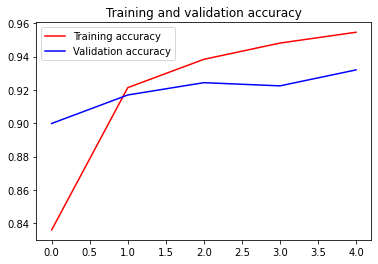

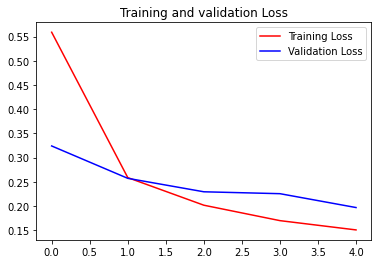

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

Saving TomatoHealthy4.JPG to TomatoHealthy4.JPG


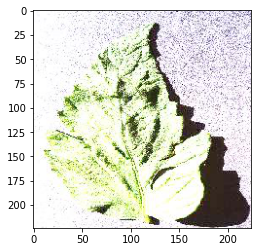

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 0.02%
Corn_(maize)___Common_rust_: 0.01%
Corn_(maize)___Northern_Leaf_Blight: 0.00%
Corn_(maize)___healthy: 0.13%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 4.73%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.02%
Tomato___Late_blight: 0.00%
Tomato___Leaf_Mold: 0.00%
Tomato___Septoria_leaf_spot: 1.18%
Tomato___Spider_mites Two-spotted_spider_mite: 0.00%
Tomato___Target_Spot: 2.03%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.79%
Tomato___healthy: 91.08%


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.applications.xception import preprocess_input

labels = train_generator.class_indices.keys()

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  proba = model.predict(images)[0]
  plt.imshow(img)
  plt.show()
  for (label, p) in zip(labels, proba):
    print("{}: {:.2f}%".format(label, p * 100))

In [ ]:
# from tensorflow.keras.preprocessing import image_dataset_from_directory

# AUTOTUNE = tf.data.AUTOTUNE

# TEST_DIR = "/tmp/Bangkit's Peasant Dataset/val/"

# test_dataset = image_dataset_from_directory(TEST_DIR,
#                                              shuffle=True,
#                                              batch_size=32,
#                                              image_size=(224, 224))

# class_names = train_dataset.class_names

# val_batches = tf.data.experimental.cardinality(test_dataset)
# test_dataset = test_dataset.take(val_batches // 5)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

In [ ]:
# #Retrieve a batch of images from the test set
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch).flatten()

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")

In [ ]:
model.save('./v3.h5')

In [ ]:
CATS_VS_DOGS_SAVED_MODEL = '/exp_saved_model/'

In [ ]:
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

INFO:tensorflow:Assets written to: /exp_saved_model/assets


INFO:tensorflow:Assets written to: /exp_saved_model/assets


In [ ]:
%%bash -s $CATS_VS_DOGS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 17)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(CATS_VS_DOGS_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 17), dtype=tf.float32, name='dense')}


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_quant_model = converter.convert()

In [ ]:
import pathlib

tflite_model_file = pathlib.Path('./pdv1.tflite')
tflite_model_file.write_bytes(tflite_quant_model)

2648912

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]